In [1]:
from google.colab import files
files.upload()

Saving forestfires.csv to forestfires.csv


{'forestfires.csv': b'X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area\r\n7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0\r\n7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0,0\r\n7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0\r\n8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0\r\n8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0,0\r\n8,6,aug,sun,92.3,85.3,488,14.7,22.2,29,5.4,0,0\r\n8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0,0\r\n8,6,aug,mon,91.5,145.4,608.2,10.7,8,86,2.2,0,0\r\n8,6,sep,tue,91,129.5,692.6,7,13.1,63,5.4,0,0\r\n7,5,sep,sat,92.5,88,698.6,7.1,22.8,40,4,0,0\r\n7,5,sep,sat,92.5,88,698.6,7.1,17.8,51,7.2,0,0\r\n7,5,sep,sat,92.8,73.2,713,22.6,19.3,38,4,0,0\r\n6,5,aug,fri,63.5,70.8,665.3,0.8,17,72,6.7,0,0\r\n6,5,sep,mon,90.9,126.5,686.5,7,21.3,42,2.2,0,0\r\n6,5,sep,wed,92.9,133.3,699.6,9.2,26.4,21,4.5,0,0\r\n6,5,sep,fri,93.3,141.2,713.9,13.9,22.9,44,5.4,0,0\r\n5,5,mar,sat,91.7,35.8,80.8,7.8,15.1,27,5.4,0,0\r\n8,5,oct,mon,84.9,32.8,664.2,3,16.7,47,4.9,0,0\r\n6,4,mar,wed,89.2,27.9,70.8,6.

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier



%matplotlib inline

df = pd.read_csv("forestfires.csv")

In [3]:
import warnings
warnings.filterwarnings("ignore")

We were not provided a source for the data but have been given feature data (columns) that aligns with other weather indices. The first step I took in the process was to create a data dictionary for reference. I found a missing metric not available in the dataset called Buildup Index (BUI). This represents total fuel available for combustion. In the absence of rain, BUI fluctuates little throughout the day. Later on, I learned that the BUI is just a combination of DMC and DC.  


In [4]:
df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

Most of the data consist of floats and integers.

In [5]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

The size of the dataset.


In [6]:
df.size

6721

The observations and rows.

In [7]:
df.shape

(517, 13)

I decided to use the entire population since there existed no null or missing values in the dataset and it was approved by the instructor Preston Menke.

In [8]:
print(df.isnull().values.any())

False


Through simply getting a unique count of the feature column for ‘month’ it is concluded that most forest fires do happen in the summer. Based on our analysis the month of August had the most forest fires with 184 out of 517. The next following month after would September which is the official month when summer ends in 2023 for the northern hemisphere according to Calendarpedia. Basically there was little to no forest fires after through the winter.

In [9]:
print(df['month'].value_counts())

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64


In the data dictionary, the area is in hectares. Close to half the results (247) are not even one hectare. One hectare contains about 2.471 acres. According to the National Wildfire Coordinating Group, a “large” fire must burn more than a specified area of land e.g., 300 acres or 121 hectares. The average size of a forest fire in the 1980s was about 30 acres or 12.1405693 hectares, for this decade it is up to 101 acres or 40.8732499 hectares (Wildfire Today).

Here are the results for the records with the most damage (i.e., over 101 acres).


In [10]:
high_damage = df[df['area']>40.8732499]
print(high_damage)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
225  4  4   sep  sun  93.5  149.3  728.6   8.1  22.9  39   4.9   0.0    48.55
226  7  5   oct  mon  91.7   48.5  696.1  11.1  16.1  44   4.0   0.0    49.37
227  8  6   aug  sat  92.2   81.8  480.8  11.9  20.1  34   4.5   0.0    58.30
228  4  6   sep  sun  93.5  149.3  728.6   8.1  28.3  26   3.1   0.0    64.10
229  8  6   aug  sat  92.2   81.8  480.8  11.9  16.4  43   4.0   0.0    71.30
230  4  4   sep  wed  92.9  133.3  699.6   9.2  26.4  21   4.5   0.0    88.49
231  1  5   sep  sun  93.5  149.3  728.6   8.1  27.8  27   3.1   0.0    95.18
232  6  4   sep  tue  91.0  129.5  692.6   7.0  18.7  43   2.7   0.0   103.39
233  9  4   sep  tue  84.4   73.4  671.9   3.2  24.3  36   3.1   0.0   105.66
234  4  5   sep  sat  92.5  121.1  674.4   8.6  17.7  25   3.1   0.0   154.88
235  8  6   aug  sun  91.4  142.4  601.4  10.6  19.6  41   5.8   0.0   196.48
236  2  2   sep  sat  92.5  121.1  674.4   8.6  18.2  46   1.8  

I created a seaborn heatmap based on the severity of damage using the X,Y coordinates.

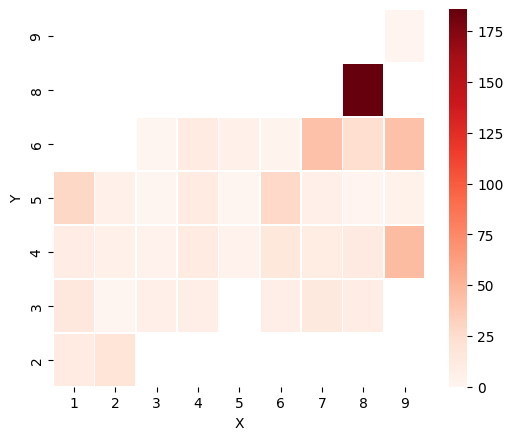

In [11]:
plt.figure(figsize=(6,5), dpi=100)
heatmap_data = pd.pivot_table(df, values='area', index='Y', columns='X')
ax=sns.heatmap(heatmap_data, linewidths=.5, cmap="Reds")
ax.invert_yaxis()
plt.show()


I also created a correlation matrix. This is simply a table showing the correlation coefficients between variables. The values can be up to 1.00 and lower than 0 which indicates no relationship. Possible values of the correlation coefficient range from -1 to +1, with -1 indicating a perfectly linear negative, i.e., inverse, correlation (sloping downward) and +1 indicating a perfectly linear positive correlation (sloping upward).

DMC and DC have the most positive linear relationship (0.682192) then other columns such as FFMC, ISI, and temperature. 

In [12]:
df.corr()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366


We added the damage feature column to the dataframe to determine of the forest fires are considered "large".

In [13]:
def fire_damage(area):
    if area <= 40.8732499:
        return "No"
    elif area > 40.8732499:
        return "Yes"

df['damage'] = df['area'].apply(fire_damage)
df_damaged = df.loc[(df['damage'] == 'Yes')]
df_damaged.head(5)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage
225,4,4,sep,sun,93.5,149.3,728.6,8.1,22.9,39,4.9,0.0,48.55,Yes
226,7,5,oct,mon,91.7,48.5,696.1,11.1,16.1,44,4.0,0.0,49.37,Yes
227,8,6,aug,sat,92.2,81.8,480.8,11.9,20.1,34,4.5,0.0,58.30,Yes
228,4,6,sep,sun,93.5,149.3,728.6,8.1,28.3,26,3.1,0.0,64.10,Yes
229,8,6,aug,sat,92.2,81.8,480.8,11.9,16.4,43,4.0,0.0,71.30,Yes


<Figure size 600x600 with 0 Axes>

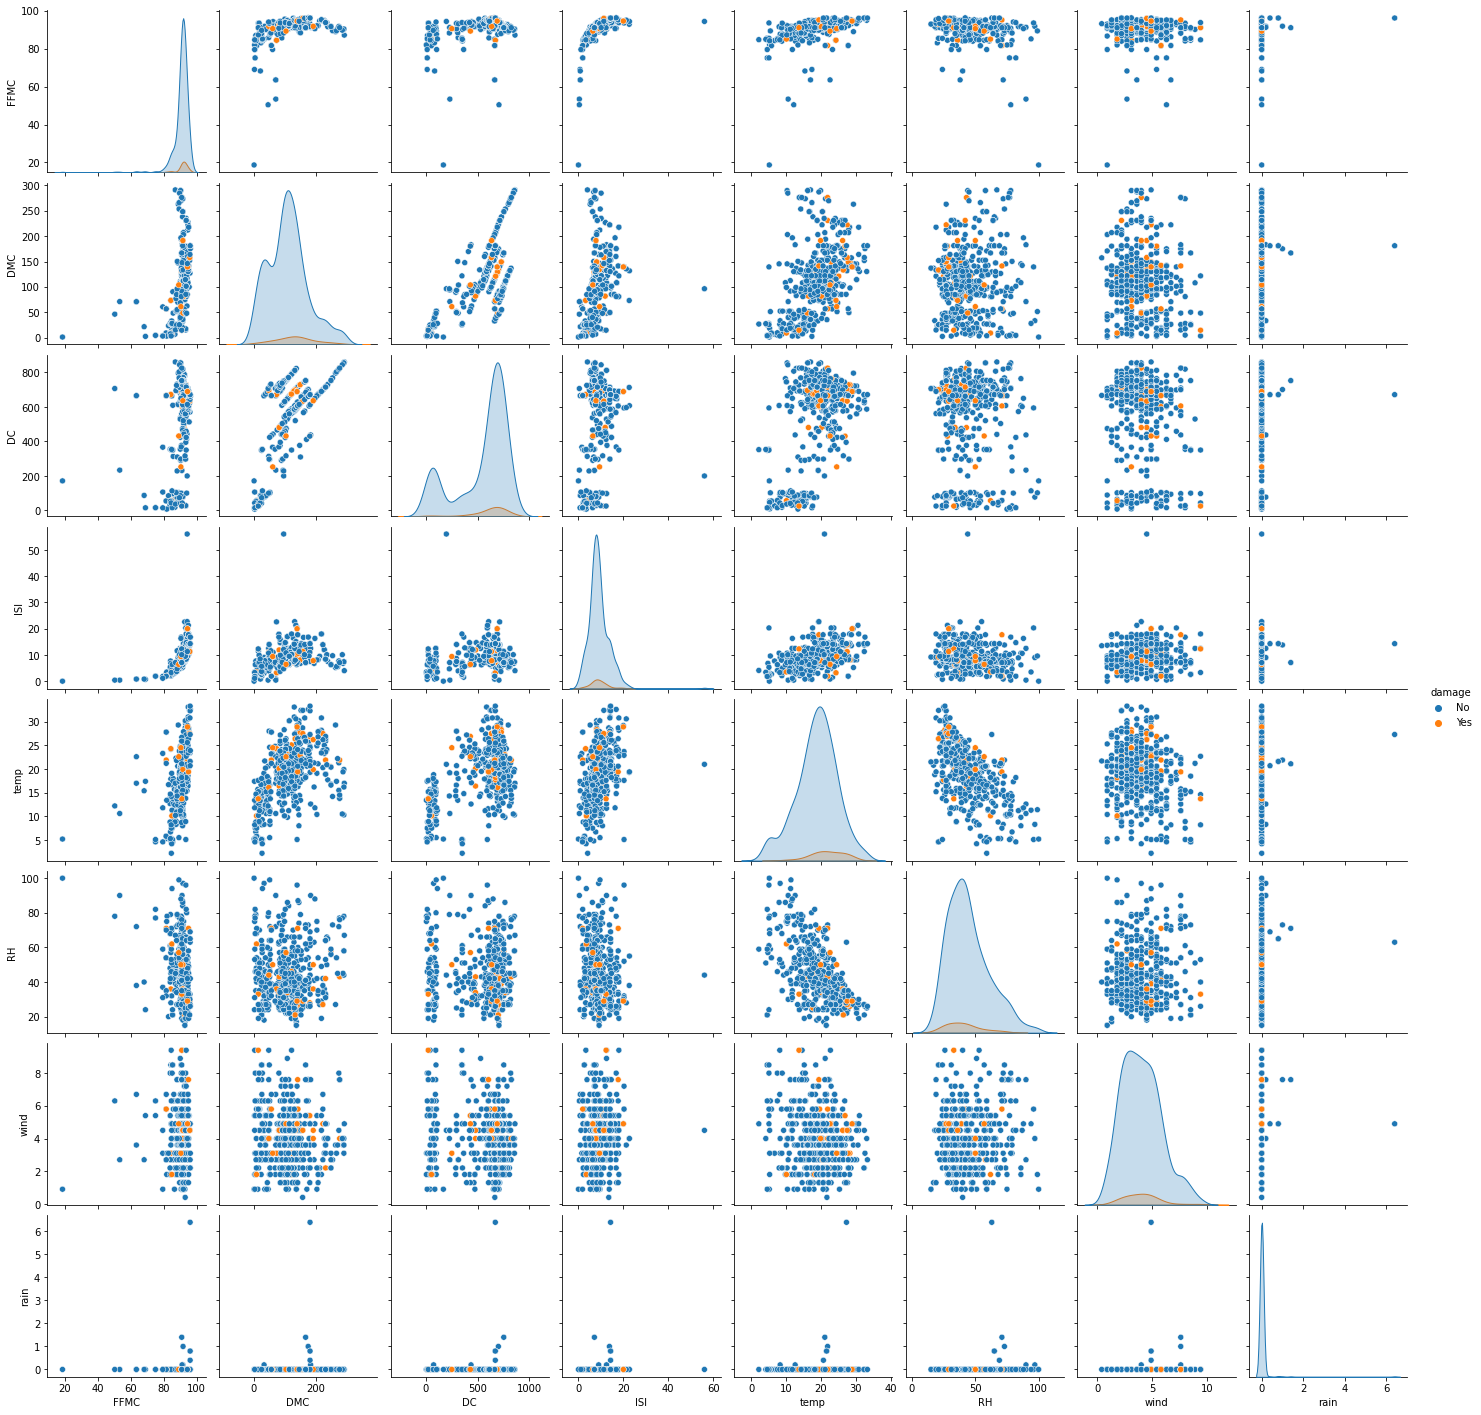

In [14]:
plt.figure(figsize=(6,6), dpi=100)
_df = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind','rain','damage']]
sns.pairplot(_df, kind="scatter", hue='damage')
plt.show()

The FWI System evaluates fuel moisture content and relative fire behavior using weather effects on ground level fuels. The moisture codes reflect the net effects of daily moisture gains and losses. As we seen in the data dictionary all have a numeric rating of the average moisture content.

We added a fine fuel featured column to the dataframe to implement the rating levels for FFMC.

There are many with very high and extreme ratings.

In [15]:
def fine_fuel(FFMC):
    if FFMC <= 80.9:
        return "Low"
    if FFMC > 80.9 and FFMC <= 87.9:
        return "Moderate"
    if FFMC > 87.9 and FFMC <= 90.4:
        return "High"
    if FFMC > 90.4 and FFMC <= 92.4:
        return "Very High"
    elif FFMC > 92.5:
        return "Extreme"

df['fine_fuel'] = df['FFMC'].apply(fine_fuel)
print(df['fine_fuel'].value_counts())

Very High    216
Extreme      144
High          71
Moderate      59
Low           12
Name: fine_fuel, dtype: int64


We added a duff featured column to the dataframe to implement the rating levels for DMC. 

There are many with very high and extreme ratings as well.

In [16]:
def duff(DMC):
    if DMC <= 12.9:
        return "Low"
    if DMC > 12.9 and DMC <= 27.9:
        return "Moderate"
    if DMC > 27.9 and DMC <= 41.9:
        return "High"
    if DMC > 41.9 and DMC <= 62.9:
        return "Very High"
    elif DMC > 63.0:
        return "Extreme"

df['duff'] = df['DMC'].apply(duff)
#df.head(5)
print(df['duff'].value_counts())

Extreme      388
Very High     41
Moderate      40
High          26
Low           22
Name: duff, dtype: int64


We added a drought feature column to the dataframe to implement the rating levels for DC. 

There are many with very high and extreme ratings as well.

In [17]:
def drought(DC):
    if DC <= 79.9:
        return "Low"
    if DC > 79.9 and DC <= 209.9:
        return "Moderate"
    if DC > 209.9 and DC <= 273.9:
        return "High"
    if DC > 273.9 and DC <= 359.9:
        return "Very High"
    elif DC > 360.0:
        return "Extreme"

df['drought'] = df['DC'].apply(duff)
#df.head(5)
print(df['drought'].value_counts())

Extreme      479
Very High     16
High          10
Moderate      10
Low            2
Name: drought, dtype: int64


I created visualizations (bar graphs) of the fuel moisture codes columns. Most are rated extreme and high.

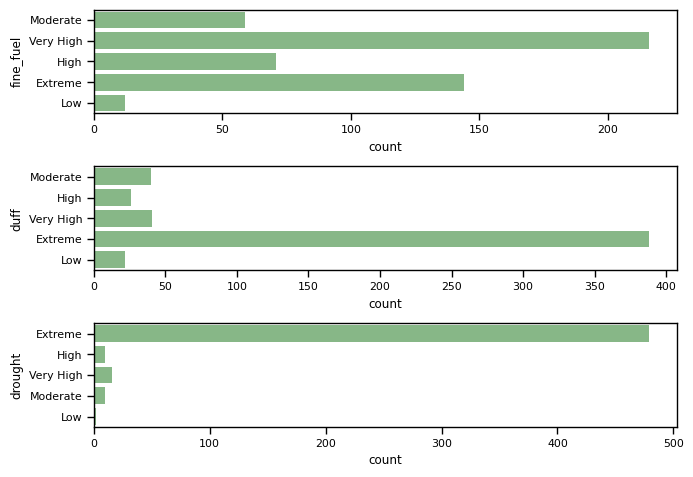

In [18]:
dfmd = df.drop(columns=['month','day','damage']) #remove specific columns
cat_columns = dfmd.select_dtypes(include='object').columns.tolist() 

plt.figure(figsize=(7,6), dpi=100)
for i,col in enumerate(cat_columns,1):
    sns.set_context("paper", font_scale=0.9)
    plt.subplot(4,1,i)
    sns.countplot(data=dfmd,y=col, color='green', alpha=0.5)
   
plt.tight_layout()
plt.show() 

# **Machine Learning**

We are now ready to start using the Decision Tree machine learning algorithm to classify fire damage based on area (hectares) . 

The first step in the process would be to drop unneccessary columns especially the dependent variables (fine_fuel, duff, drought) created earlier.



In [19]:
df_ml = df.drop(['X','Y','month','day','fine_fuel','duff','drought'], axis=1)
df_ml.head(10)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No
5,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0,No
6,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0,No
7,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0,No
8,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0,No
9,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0,No


In order to use Sci-Kit learn, dataframes need to be converted to NumPy arrays.

Independent variables are stored in matrix called X, and dependent/target variable (damage) is stored in matrix called y.

In [20]:
X = df_ml.drop('damage', axis=1).values.astype(float)
X[0:5]

y = df_ml['damage'].values
y[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

Next, is preprocessing - we transform the feature columns/data (normalization) to use one scale with a mean of 0 and standard deviation of 1. 

In [21]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.80595947, -1.32332557, -1.83047676, -0.86094557, -1.84264015,
         0.41172435,  1.49861442, -0.07326831, -0.20201979],
       [-0.00810203, -1.17954077,  0.48889092, -0.50968827, -0.15327826,
        -0.69245628, -1.74175564, -0.07326831, -0.20201979],
       [-0.00810203, -1.04982188,  0.56071545, -0.50968827, -0.73938341,
        -0.69245628, -1.51828184, -0.07326831, -0.20201979],
       [ 0.19136233, -1.21236122, -1.89826621, -0.0047559 , -1.82540176,
         3.23351928, -0.00983371,  0.60315519, -0.20201979],
       [-0.24383264, -0.93104314, -1.79859958,  0.12696559, -1.29101178,
         3.35620602, -1.23893959, -0.07326831, -0.20201979]])

As stated, one of the best machine learning algorithm for the dataset would be logistic regression since we want to use categorical variables but we cannot use what we learned in class.

It is still best to train with 80% of the data, use 10% for validation, and test with 10% due to the size of the dataset.

Validation Set - The validation set is a set of data, separate from the training set, that is used to validate our model performance during training. The main idea of splitting the dataset into a validation set is to prevent our model from overfitting i.e., the model becomes really good at classifying the samples in the training set but cannot generalize and make accurate classifications on the data it has not seen before. 

Test Set - The test set is a separate set of data used to test the model after completing the training. It provides an unbiased final model performance metric in terms of accuracy, precision, etc. To put it simply, it answers the question of "How well does the model perform?" 


In [22]:
#https://datascience.stackexchange.com/a/53161

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 80% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

Another way to train and test the dataset.

I printed the observations and rows using shape.

In [23]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
print('Train set:', X.shape,  y.shape)
print('Test set:', X_test.shape,  y_test.shape)

Train set: (465, 9) (465,)
Test set: (52, 9) (52,)


**criterion**: {“gini”, “entropy”, “log_loss”}, default=”gini”
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.

Gini index and entropy is the criterion for calculating information gain. Decision tree algorithms use information gain to split a node. Both gini and entropy are measures of impurity of a node. A node having multiple classes is impure whereas a node having only one class is pure.

**max_depth**: int, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.



In [24]:
decisiontree = tree.DecisionTreeClassifier()
#I added all the criterion although example states gini and entropy as only options for this dataset
criterion = ['gini', 'entropy']
max_depth = range(1,20)

#Create a dictionary of all meter options 
param = dict(criterion=criterion, max_depth=max_depth)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
clf_DT=GridSearchCV(decisiontree, param, cv=10)
best_model = clf_DT.fit(X, y)
print('Best Criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Best Criterion: gini
Best max_depth: 1


 **K-fold cross validation for Decision Tree** 

Setting a random_state has no effect when shuffle is False so I left the random_state to its default (None). We can also set shuffle=True and random_state=1 as an alternative workaround.

In [25]:
crossvalidation = KFold(n_splits=10, random_state=1,shuffle=True)
DT = DecisionTreeClassifier(criterion="gini", max_depth = 1)
model_DT=DT.fit(X,y)

scores = cross_val_score(model_DT, X, y, scoring="accuracy", cv=crossvalidation, n_jobs=1)

y_hat_DT = cross_val_predict(DT, X, y, cv=crossvalidation)

In [26]:
d_y_dtree = {'True_value': y, 'Predicted_value': y_hat_DT}
comparison_y_DT = pd.DataFrame(data=d_y_dtree)
comparison_y_DT

,True_value,Predicted_value
0,No,No
1,No,No
2,No,No
3,No,No
4,No,No
...,...,...
460,No,No
461,No,No
462,No,No
463,No,No


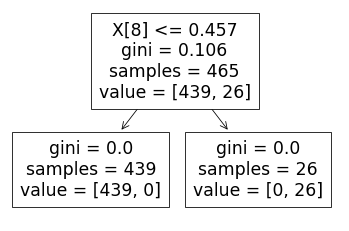

In [27]:
tree.plot_tree(DT) 
plt.show()

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_hat_DT, labels=['Yes','No'])
np.set_printoptions(precision=2)

In [29]:
accuracy_DT=(cnf_matrix[0,0]+cnf_matrix[1,1])/517
print ('Accuracy_DT : ', '{:.2f}'.format(accuracy_DT))

sensitivity_DT = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print('Sensitivity_DT : ', '{:.2f}'.format(sensitivity_DT))

specificity_DT = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print('Specificity_DT : ','{:.2f}'.format(specificity_DT))

Accuracy_DT :  0.90
Sensitivity_DT :  0.96
Specificity_DT :  1.00


Test the final model on the test set to check for accuracy:

In [30]:
yhat = model_DT.predict(X_test)

In [31]:
d_y_dt = {'True_value': y_test, 'Predicted_value': yhat}
comparison = pd.DataFrame(data=d_y_dt)
comparison.head(50)

,True_value,Predicted_value
0,Yes,Yes
1,No,No
2,No,No
3,No,No
4,No,No
5,No,No
6,Yes,Yes
7,No,No
8,No,No
9,No,No


In [49]:
#print(accuracy_DT,sensitivity_DT,specificity_DT)
plt.show()

In [32]:
print("Test Set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Test Set Accuracy:  1.0
